In [1]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import pandas as pd
from cloudy_fit_lib import *
from scipy.interpolate import RegularGridInterpolator
import pickle
import corner
from scipy import integrate, interpolate
import emcee
from astropy import units,constants

In [2]:
plt.style.use('/Users/thepoetoftwilight/Documents/CUBS/Code/science.mplstyle')

In [3]:
rootdir = '/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/cloudy_grids/'

In [4]:
savedir = '/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z=0.67545705/cloudy_fits/'

Obtain the UVB grid from FG20

In [5]:
fg20_z_grid, fg20_wav_grid, fg20_J_nu_grid = read_uvb('', 'fg20_galaxy.ascii')

Fetch the SED at $z=1$

In [6]:
z_test = 1

In [7]:
fg20_J_nu_test = fetch_sed(z_test, fg20_z_grid, fg20_J_nu_grid)

Specify $N_{\mathrm{HI}}$ grid points and get corresponding filenames

In [8]:
logN_HI_min = 12
logN_HI_max = 17
logN_HI_step = 0.25

logN_HI_arr = np.arange(logN_HI_min, logN_HI_max+logN_HI_step, logN_HI_step)

In [9]:
file_list = create_grid_file_list(logN_HI_arr)

Specify grid points for densities and metallicities

In [10]:
log_hdens_min = -5
log_hdens_max = 1
log_hdens_step = 0.25

log_hdens_arr = np.arange(log_hdens_min, log_hdens_max+log_hdens_step, log_hdens_step)
logU_arr = np.log10(calc_U(fg20_wav_grid, fg20_J_nu_test, 10**log_hdens_arr))

In [11]:
log_metals_min = -3
log_metals_max = 1
log_metals_step = 0.25

log_metals_arr = np.arange(log_metals_min, log_metals_max+log_metals_step, log_metals_step)

Load the final grid

In [12]:
pkl_file = open(rootdir+'final_grid.pkl', 'rb')
species_logN_samples = pickle.load(pkl_file)
pkl_file.close()

Interpolate this grid

In [13]:
species_logN_interp = {}

for s in list(species_logN_samples.keys()):
    
    species_logN_samples[s][species_logN_samples[s]==-np.inf] = -99
    
    species_logN_interp[s] = RegularGridInterpolator((logN_HI_arr, log_hdens_arr, log_metals_arr), 
                                                     species_logN_samples[s])

# Calculations

## Jeans length ($n_\mathrm{H} = 10^{-3} \ \mathrm{cm}^{-3}$)

Jeans length as a function of density

In [14]:
k_B = 1.38 * 1e-16 # erg/K
G = 6.67 * 1e-8 # erg cm g^-2
gamma = 5/3 # Monatomic gas
mu = 0.607 # Mean molecular weight for ionized plasma? Taken from Draine
T_fid = 1e4 # K
n_H_fid = 10**-3 # cm^-3
m_H = 1.67 * 1e-24 # in g

Sound speed calculation

In [15]:
c_s = np.sqrt(gamma*constants.k_B*T_fid*units.K/(mu*constants.m_p)).to(units.km/units.s)

In [16]:
c_s*np.sqrt(2)

<Quantity 21.29059389 km / s>

In [17]:
np.sqrt(gamma*k_B*2*T_fid/(0.607*m_H))/1e5 # Sound speed

21.302292062382623

Dynamical time calculation

In [18]:
(1/np.sqrt(constants.G*constants.m_p*1*units.cm**-3)).to(units.s)

<Quantity 2.99294162e+15 s>

Cloud size calculation

In [19]:
l = (c_s*np.sqrt(np.pi/(constants.G*mu*constants.m_p*n_H_fid*units.cm**-3))).to(units.kpc)

In [20]:
l

<Quantity 105.05121251 kpc>

In [25]:
l_jeans = np.sqrt((np.pi*gamma*k_B*T_fid)/(G*(mu*m_H)**2))*(n_H_fid**-0.5)*3.24078e-22

In [26]:
l_jeans

105.22533696555298

In [27]:
# Correct for dark matter
l_jeans*np.sqrt(0.16)

42.0901347862212

## Sonic length ($n_\mathrm{H} = 10^{-3} \ \mathrm{cm}^{-3}$)

In [28]:
N_H_sonic = 1e17

In [30]:
l_sonic = (N_H_sonic/n_H_fid)*3.24078e-22

In [31]:
l_sonic

0.0324078

# Plots for different densities

In [32]:
log_hdens_arr = np.arange(-5, -1, 0.1)

log_lJ_arr = np.log10(40*(10**log_hdens_arr/1e-3)**-0.5)
log_lS_arr = np.log10(0.03*(10**log_hdens_arr/1e-3)**-1)

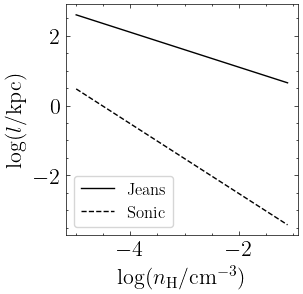

In [38]:
fig, ax = plt.subplots(1, figsize=(3,3))

ax.plot(log_hdens_arr, log_lJ_arr, color='black', label='Jeans')
ax.plot(log_hdens_arr, log_lS_arr, color='black', linestyle='--', label='Sonic')

ax.set_xlabel(r'$\log(n_\mathrm{H}/\mathrm{cm}^{-3})$')
ax.set_ylabel(r'$\log(l/\mathrm{kpc})$')

ax.legend()